### 자동 미분 (torch.autograd)

- PyTorch의 autograd 는 신경망 훈련을 지원하는 자동 미분 가능
- torch.autograd 동작 방법
    - 텐서에 .requires_grad 속성을 True로 설정하면, 이후의 텐서 모든 연산들을 추적함
    - 텐서.backward() 를 호출하면, 연산에 연결된 각 텐서들의 미분 값을 계산하여, 각 텐서 객체에 .grad에 저장
        - .requires_grad_()는 연결된 Tensor로부터의 계산된 자동미분 값을, 다시 현 텐서부터 시작하도록 만듦

### 신경망 동작 이해

- 모델 및 데이터 생성
- forward pass로 입력 데이터를 모델에 넣어서 예측값 계산
- 예측값과 실제값의 차이를 loss function 으로 계산
- backward pass 로 각 모델 파라미터를 loss 값 기반 미분하여 저장
- optimizer 로 모델 파라미터의 최적값을 찾기 위해, 파라미터 값 업데이트

- 텐서에 .requires_grad 속성을 True 로 설정
- .requires_grad 속성이 True 로 설정되면, 텐서의 모든 연산 추적을 위해, 내부적으로 방향성 비순환 그래프(DAG : Directed Acyclic Graph)를 동적 구성
    - 방향성 비순환 그래프(DAG)의 leaf 노드는 입력 텐서이고, root 노드는 결과 텐서가 됨

In [15]:
import torch

x = torch.rand(1, requires_grad=True)
y = torch.rand(1)
y.requires_grad = True
loss = y - x

### 🔁 텐서의 `.backward()` 동작 설명

- `tensor.backward()` 를 호출하면,  
  연산에 연결된 각 텐서들의 **미분 값(gradient)**을 자동으로 계산하여  
  각 텐서 객체의 `.grad` 속성에 저장된다.

---

### 🎯 예시

$$
\frac{\partial \text{Loss}}{\partial x} = -1, \quad \frac{\partial \text{Loss}}{\partial y} = 1
$$

> 즉, Loss를 기준으로 각 입력값에 대한 **기울기(gradient)**가 계산되어  
> `.grad` 속성에 자동으로 저장된다.

In [16]:
loss.backward()
print(x.grad, y.grad)

tensor([-1.]) tensor([1.])


In [17]:
x = torch.ones(4)
y = torch.zeros(3)
W = torch.rand(4, 3, requires_grad=True)
b = torch.rand(3, requires_grad=True)
z = torch.matmul(x,W) + b
print(W, b, z)

tensor([[0.1585, 0.6102, 0.5972],
        [0.7539, 0.8972, 0.9954],
        [0.8169, 0.9658, 0.9572],
        [0.7603, 0.8970, 0.4142]], requires_grad=True) tensor([0.0068, 0.2385, 0.3447], requires_grad=True) tensor([2.4964, 3.6086, 3.3087], grad_fn=<AddBackward0>)


In [18]:
import torch.nn.functional as F

loss = F.mse_loss(z, y)
loss.backward()
print(loss, W.grad, b.grad)


tensor(10.0673, grad_fn=<MseLossBackward0>) tensor([[1.6643, 2.4058, 2.2058],
        [1.6643, 2.4058, 2.2058],
        [1.6643, 2.4058, 2.2058],
        [1.6643, 2.4058, 2.2058]]) tensor([1.6643, 2.4058, 2.2058])


In [19]:
threshold = 0.1
learning_rate = 0.1
iteration_num = 0

while loss > threshold :
    iteration_num += 1
    W = W - learning_rate * W.grad
    b = b - learning_rate * b.grad
    print(iteration_num, loss, z, y)
    
    # detach_() : 텐서를 기존 방향성 비순환 그래프(DAG : Directed Acyclic Graph) 로부터 끊음
    # .requires_grad(True) : 연결된 Tensor 로부터의 계산된 자동미분 값을, 다시 현 텐서부터 시작하도록 만듦
    W.detach_().requires_grad_(True)
    b.detach_().requires_grad_(True)

    z = torch.matmul(x, W) + b
    loss = F.mse_loss(z, y)
    loss.backward()

print(iteration_num + 1, loss, z, y)

1 tensor(10.0673, grad_fn=<MseLossBackward0>) tensor([2.4964, 3.6086, 3.3087], grad_fn=<AddBackward0>) tensor([0., 0., 0.])
2 tensor(4.4744, grad_fn=<MseLossBackward0>) tensor([1.6643, 2.4058, 2.2058], grad_fn=<AddBackward0>) tensor([0., 0., 0.])
3 tensor(1.9886, grad_fn=<MseLossBackward0>) tensor([1.1095, 1.6038, 1.4705], grad_fn=<AddBackward0>) tensor([0., 0., 0.])
4 tensor(0.8838, grad_fn=<MseLossBackward0>) tensor([0.7397, 1.0692, 0.9804], grad_fn=<AddBackward0>) tensor([0., 0., 0.])
5 tensor(0.3928, grad_fn=<MseLossBackward0>) tensor([0.4931, 0.7128, 0.6536], grad_fn=<AddBackward0>) tensor([0., 0., 0.])
6 tensor(0.1746, grad_fn=<MseLossBackward0>) tensor([0.3287, 0.4752, 0.4357], grad_fn=<AddBackward0>) tensor([0., 0., 0.])
7 tensor(0.0776, grad_fn=<MseLossBackward0>) tensor([0.2192, 0.3168, 0.2905], grad_fn=<AddBackward0>) tensor([0., 0., 0.])


### Optimizer 와 경사 하강법

- 최적화는 각 학습 단계에서 모델의 오류를 줄이기 위해서 모델 매개변수를 조정하는 과정으로 Optimizer는 최적화 알고리즘을 의미합니다.
- 대표적인 최적화 알고리즘에는 확률적 경사하강법(SGD: Stochastic Gradient Descent)
- PyTorch 에는 모델과 데이터 타입에 따라, 보다 좋은 성능을 제공하는 ADAM 이나 RMSProp과 같은 다양한 옵티마이저가 존재합니다.

In [20]:
import torch

w = torch.tensor(4.0, requires_grad=True)
z = 2 * w
z.backward()
print(w.grad)

z = 2 * w
z.backward()
print(w.grad)

z = 2 * w
z.backward()
print(w.grad)

tensor(2.)
tensor(4.)
tensor(6.)


### SGD 경사하강법 Optimizer 적용

In [21]:
import torch

x = torch.ones(4)
y = torch.zeros(3)

W = torch.rand(4, 3, requires_grad=True)
b = torch.rand(3, requires_grad=True)

In [22]:
learning_rate = 0.01
optimizer = torch.optim.SGD([W, b], lr=learning_rate)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [23]:
nb_epochs = 300  # 원하는 만큼 경사하강법 반복
for epoch in range(nb_epochs + 1):
    
    z = torch.matmul(x, W) + b
    loss = F.mse_loss(z, y)
    
    optimizer.zero_grad() # 기울기 초기화
    loss.backward() # 기울기 계산
    optimizer.step() # 파라미터 업데이트 
    
    if epoch % 100 == 0:
        print(epoch, nb_epochs, W, b, loss)

0 300 tensor([[0.8420, 0.1585, 0.0583],
        [0.2627, 0.6816, 0.9305],
        [0.3108, 0.6757, 0.8515],
        [0.2905, 0.8326, 0.9512]], requires_grad=True) tensor([0.2471, 0.8214, 0.9094], requires_grad=True) tensor(9.8308, grad_fn=<MseLossBackward0>)
100 300 tensor([[ 0.4645, -0.4541, -0.6569],
        [-0.1147,  0.0690,  0.2152],
        [-0.0667,  0.0631,  0.1363],
        [-0.0870,  0.2200,  0.2359]], requires_grad=True) tensor([-0.1303,  0.2088,  0.1942], requires_grad=True) tensor(0.0112, grad_fn=<MseLossBackward0>)
200 300 tensor([[ 0.4518, -0.4747, -0.6810],
        [-0.1275,  0.0483,  0.1911],
        [-0.0794,  0.0425,  0.1122],
        [-0.0997,  0.1994,  0.2118]], requires_grad=True) tensor([-0.1431,  0.1881,  0.1701], requires_grad=True) tensor(1.2685e-05, grad_fn=<MseLossBackward0>)
300 300 tensor([[ 0.4514, -0.4754, -0.6818],
        [-0.1279,  0.0476,  0.1903],
        [-0.0798,  0.0418,  0.1114],
        [-0.1001,  0.1987,  0.2110]], requires_grad=True) tensor([

### SGD 경사하강법 Optimizer 적용 (PyTorch 신경망 모델 클래스 기반)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel(4,3)
model

LinearRegressionModel(
  (linear): Linear(in_features=4, out_features=3, bias=True)
)

In [25]:
x = torch.ones(4)
y = torch.zeros(3)

learning_rate = 0.01
nb_epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(nb_epochs + 1):
    
    pred = model(x)
    loss = F.mse_loss(pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [26]:
print(loss)
for param in model.parameters():
    print(param)

tensor(2.4874e-14, grad_fn=<MseLossBackward0>)
Parameter containing:
tensor([[ 0.0121,  0.4014, -0.2788, -0.3444],
        [ 0.0059, -0.4401,  0.2281,  0.2633],
        [-0.2843, -0.0418,  0.3556, -0.3609]], requires_grad=True)
Parameter containing:
tensor([ 0.2097, -0.0572,  0.3314], requires_grad=True)


In [27]:
import torch
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes


diabetes_data = load_diabetes()

print(diabetes_data.DESCR) # 데이터 세트에 대한 전체 설명

x = torch.from_numpy(np.array(diabetes_data.data[:,:-1],dtype=np.float32))
y = torch.from_numpy(np.array(diabetes_data.data[:,[-1]],dtype=np.float32))

print(x.shape)
print(y.shape)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [28]:
x.size(1)

9

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel(x.size(1), y.size(1))
model

LinearRegressionModel(
  (linear): Linear(in_features=9, out_features=1, bias=True)
)

In [33]:
learning_rate = 0.01
nb_epochs = 10000

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

for epoch in range(nb_epochs + 1):
    
    y_pred = model(x)
    loss = F.mse_loss(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [34]:
y_pred.shape

torch.Size([442, 1])

In [35]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0807,  0.1439,  0.0961, -0.0918,  0.0151,  0.2049, -0.2188, -0.1825,
          0.3418]], requires_grad=True)
Parameter containing:
tensor([1.8340e-10], requires_grad=True)


In [37]:
df = pd.DataFrame(torch.concat([y, y_pred],dim=1).detach_().numpy(),columns=["y","y_pred"])
df

,y,y_pred
0,-0.017646,0.017110
1,-0.092204,-0.045283
2,-0.025930,0.006037
3,-0.009362,0.017698
4,-0.046641,-0.021350
...,...,...
437,0.007207,0.017126
438,0.044485,0.023209
439,0.015491,-0.011123
440,-0.025930,0.020911


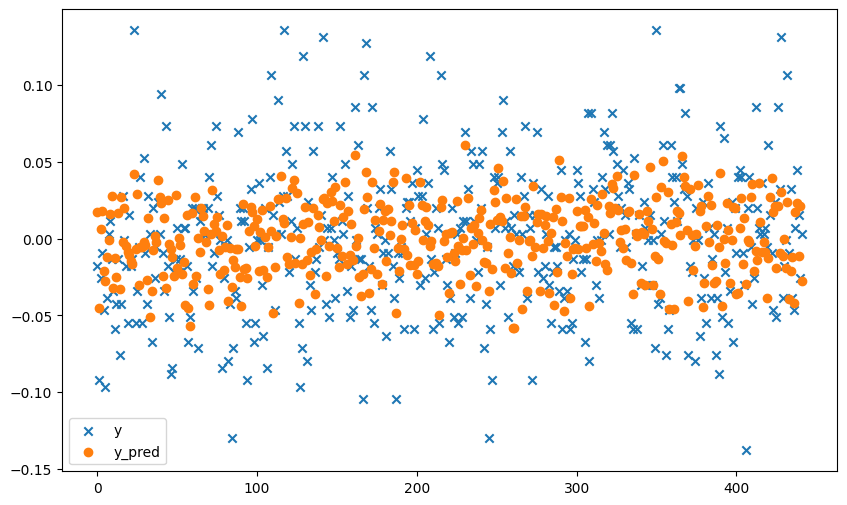

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10,6))
plt.scatter(x=df.index,y=df['y'],marker="x", label='y')
plt.scatter(x=df.index,y=df['y_pred'],marker="o", label='y_pred')

plt.legend()

plt.show()